## Introduction

## Seeds

## 3 Zarr Optimize Algorithm

### 3.1 Description

The idea of this algorithm is to exploit the chunking of the cloud-native Zarr format in order to load only those parts of the Sentinel-2 scenes that are actually needed.

1. First, we create a 10 km × 10 km grid (EPSG:5325) that covers the whole of Iceland.  
2. Then we load the seeds (GeoJSON points) and mark every grid cell as a *candidate* that contains at least one seed point.  
3. For each *candidate* 10 km × 10 km cell, we query the Sentinel-2 L2A collection via [STAC](https://stac.core.eopf.eodc.eu/collections/sentinel-2-l2a/items) to find all images in the given month whose footprint intersects the cell.  
4. We then use the chunking of the Zarr format to extract only those chunks whose spatial extent overlaps the *candidate* cell and reproject to EPSG:5325.  
5. From all extracted data within the 10 km × 10 km *candidate* cell, we calculate the Normalized Difference Snow Index (NDSI).  
6. Based on these NDSI Values, we compute the median NDSI in the time-period (to reduce measurement noise and cloud contamination).   
7. Every pixel with NDSI > 0.42 is classified as snow/ice.  
8. If more than 30% of the pixels within a 10 km × 10 km *candidate* cell are classified as snow/ice, all 4-neighbouring 10 km × 10 km cells (that have not yet been processed) are also marked as *candidate* cells.  
9. The algorithm repeats steps 3 to 8 until no additional *candidate* cells remain.


### 3.2 Implementation

#### 3.2.1 Step 0: Imports and Configuration

In [1]:
# Standard libraries
import warnings
warnings.filterwarnings('ignore')

# Geospatial libraries
import geopandas as gpd
from shapely.geometry import box, Point
import pyproj

# Data processing
import xarray as xr
import numpy as np
import pandas as pd
import dask.array
import rioxarray  # For CRS handling and reprojection
from rasterio.transform import from_bounds

# STAC API for Sentinel-2 data
from pystac_client import Client

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import folium
from folium import plugins

# Configuration
EPSG_ICELAND = 5325  # ISN2004 / Lambert 2004
BOUNDING_BOX_ICELAND = [1400000,100000,2000000,500000]
GRID_SIZE = 10000  # 10 km in meters
NDSI_THRESHOLD = 0.42
SNOW_PERCENTAGE_THRESHOLD = 0.30

print("All libraries successfully imported")

All libraries successfully imported


#### 3.2.2 Step 1: Load and Visualize Seeds

The seeds are glacier polygons from CORINE Land Cover (CLC). We load the seed points from the GeoJSON file and display an initial overview.

In [2]:
# Load seeds
seeds = gpd.read_file('data/Iceland_Seeds.geojson')

# Check CRS and transform to EPSG:5325 if necessary
print(f"Original CRS: {seeds.crs}")
if seeds.crs.to_epsg() != EPSG_ICELAND:
    seeds = seeds.to_crs(epsg=EPSG_ICELAND)
    print(f"Transformed to EPSG:{EPSG_ICELAND}")

# Overview of the seeds
print(f"\nNumber of seed points: {len(seeds)}")
print(f"\nFirst 3 seeds:")
print(seeds.head(3))

# Get bounds of the seeds
bounds = seeds.total_bounds
print(f"\nBounding box of seeds (EPSG:{EPSG_ICELAND}):")
print(f"   X: [{bounds[0]:.0f}, {bounds[2]:.0f}]")
print(f"   Y: [{bounds[1]:.0f}, {bounds[3]:.0f}]")

Original CRS: EPSG:5325

Number of seed points: 21

First 3 seeds:
   fid  OBJECTID   SHAPE_Leng     SHAPE_Area       ID CODE_18  Area_Ha Remark  \
0    1      1221  2667.362684  446026.038778  IS_1221     335     44.6   None   
1    2      1221  2667.362684  446026.038778  IS_1221     335     44.6   None   
2    3      1221  2667.362684  446026.038778  IS_1221     335     44.6   None   

                         geometry  
0  POINT (1690237.018 148953.104)  
1   POINT (1671374.378 165983.26)  
2  POINT (1667255.601 188341.711)  

Bounding box of seeds (EPSG:5325):
   X: [1473319, 1933828]
   Y: [148953, 437948]


Visualization of seed points:

In [3]:
# Interactive visualization of the seeds with satellite imagery
seeds_wgs84 = seeds.to_crs(epsg=4326)

# Calculate center of Iceland for map
center_lat = seeds_wgs84.geometry.y.mean()
center_lon = seeds_wgs84.geometry.x.mean()

# Create interactive map with satellite imagery
map_seeds = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=6,
    tiles=None
)

# Add Esri World Imagery
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri World Imagery',
    name='Satellite Imagery',
    overlay=False,
    control=True
).add_to(map_seeds)

# Add seed points to map
for idx, row in seeds_wgs84.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=6,
        color='red',
        fill=True,
        fillColor='red',
        fillOpacity=0.5,
        popup=f"Seed {idx}",
        tooltip="Glacier Seed"
    ).add_to(map_seeds)

# Add layer control
folium.LayerControl().add_to(map_seeds)

print(f"Step 1 completed: {len(seeds)} seeds loaded and visualized")
print("Interactive map created with satellite imagery background")

# Display map
map_seeds

Step 1 completed: 21 seeds loaded and visualized
Interactive map created with satellite imagery background


#### 3.2.3 Step 2: Create 10 km × 10 km Grid

We create a regular 10 km × 10 km grid that covers all of Iceland, and mark every grid cell as a *candidate* that contains at least one seed point.

In [4]:
def create_grid(bounds, grid_size):
    """
    Creates a regular grid with the given cell size and bounding box.
    
    Parameters:
    -----------
    bounds : tuple
        (xmin, ymin, xmax, ymax) in meters
    grid_size : int
        Size of a grid cell in meters
        
    Returns:
    --------
    gpd.GeoDataFrame with grid cells
    """
    xmin, ymin, xmax, ymax = bounds
    
    # Round the grid boundaries to multiples of grid_size
    xmin = np.floor(xmin / grid_size) * grid_size
    ymin = np.floor(ymin / grid_size) * grid_size
    xmax = np.ceil(xmax / grid_size) * grid_size
    ymax = np.ceil(ymax / grid_size) * grid_size
    
    # Create grid cells
    grid_cells = []
    grid_ids = []
    cell_id = 0
    
    y = ymin
    while y < ymax:
        x = xmin
        while x < xmax:
            # Create a box per grid cell
            cell = box(x, y, x + grid_size, y + grid_size)
            grid_cells.append(cell)
            grid_ids.append(cell_id)
            cell_id += 1
            x += grid_size
        y += grid_size
    
    # Create GeoDataFrame
    grid = gpd.GeoDataFrame({
        'cell_id': grid_ids,
        'geometry': grid_cells
    }, crs=f"EPSG:{EPSG_ICELAND}")
    
    return grid

# Create grid
grid = create_grid(BOUNDING_BOX_ICELAND, GRID_SIZE)

print(f"Grid created:")
print(f"Number of grid cells: {len(grid)}")
print(f"Cell size: {GRID_SIZE/1000} km × {GRID_SIZE/1000} km")

Grid created:
Number of grid cells: 2400
Cell size: 10.0 km × 10.0 km


Now we mark every cell, which contains a seed, as a candidate

In [5]:
# Mark grid cells with seeds as candidates
def mark_candidate_cells(grid, seeds):
    """
    Marks grid cells that contain at least one seed.
    
    Parameters:
    -----------
    grid : gpd.GeoDataFrame
        GeoDataFrame with grid cells
    seeds : gpd.GeoDataFrame
        GeoDataFrame with seed points
        
    Returns:
    --------
    gpd.GeoDataFrame with additional columns:
        - is_candidate: bool indicating if the cell contains seeds
        - seed_count: number of seeds in the cell
    """
    # Initialize all cells as non-candidates
    grid['is_candidate'] = False
    grid['seed_count'] = 0
    
    # Spatial join: which grid cells contain which seeds?
    joined = gpd.sjoin(grid, seeds, how='inner', predicate='contains')
    
    # Count seeds per grid cell (only for cells with seeds)
    if len(joined) > 0:
        candidate_counts = joined.groupby('cell_id').size()
        
        # Mark only cells that contain seeds as candidates
        grid.loc[grid['cell_id'].isin(candidate_counts.index), 'is_candidate'] = True
        grid.loc[grid['cell_id'].isin(candidate_counts.index), 'seed_count'] = \
            grid.loc[grid['cell_id'].isin(candidate_counts.index), 'cell_id'].map(candidate_counts)
    
    return grid

grid = mark_candidate_cells(grid, seeds)

# Statistics
n_candidates = grid['is_candidate'].sum()
print(f"\n Grid statistics:")
print(f"   Total grid cells: {len(grid)}")
print(f"   Candidate cells: {n_candidates}")
print(f"   Seeds per candidate (average): {grid[grid['is_candidate']]['seed_count'].mean():.1f}")


 Grid statistics:
   Total grid cells: 2400
   Candidate cells: 21
   Seeds per candidate (average): 1.0


Then we create an interactive visualization, which displays the Seeds, Grid, candidate cells and a background satellite images:

In [6]:
# Interactive visualization: Grid with candidate cells on satellite imagery

# Transform to WGS84 for mapping
grid_wgs84 = grid.to_crs(epsg=4326)
candidates_wgs84 = grid_wgs84[grid_wgs84['is_candidate']]
non_candidates_wgs84 = grid_wgs84[~grid_wgs84['is_candidate']]
seeds_wgs84 = seeds.to_crs(epsg=4326)

# Calculate center for map
center_lat = seeds_wgs84.geometry.y.mean()
center_lon = seeds_wgs84.geometry.x.mean()

# Create interactive map with satellite imagery
map_grid = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=6,
    tiles=None
)

# Add Esri World Imagery
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri World Imagery',
    name='Satellite Imagery',
    overlay=False,
    control=True
).add_to(map_grid)

# Add ALL grid cells
folium.GeoJson(
    non_candidates_wgs84,
    name='All Grid Cells',
    style_function=lambda x: {
        'fillColor': 'lightblue',
        'color': 'lightgray',
        'weight': 0.5,
        'fillOpacity': 0.1,
        'opacity': 0.4
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['cell_id'],
        aliases=['Cell ID:'],
        localize=True
    )
).add_to(map_grid)

# Add candidate cells
folium.GeoJson(
    candidates_wgs84[['cell_id', 'seed_count', 'geometry']],
    name='Candidate Cells',
    style_function=lambda x: {
        'fillColor': 'blue',
        'color': 'darkblue',
        'weight': 2.5,
        'fillOpacity': 0.4,
        'opacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['cell_id', 'seed_count'],
        aliases=['Cell ID:', 'Seeds:'],
        localize=True
    ),
    popup=folium.GeoJsonPopup(
        fields=['cell_id', 'seed_count'],
        aliases=['Cell ID:', 'Number of Seeds:']
    )
).add_to(map_grid)

# Add seed points as feature group
seed_group = folium.FeatureGroup(name='Glacier Seeds')
for idx, row in seeds_wgs84.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color='red',
        fill=True,
        fillColor='red',
        fillOpacity=0.7,
        popup=f"<b>Seed {idx}</b>",
        tooltip="Glacier Seed"
    ).add_to(seed_group)

seed_group.add_to(map_grid)

# Add fullscreen button
plugins.Fullscreen().add_to(map_grid)

# Add layer control (allows toggling layers on/off)
folium.LayerControl(collapsed=False).add_to(map_grid)

print(f"Step 2 completed: Grid with {n_candidates} candidate cells created")
print(f"Interactive map created with {len(grid)} grid cells ({n_candidates} highlighted as candidates)")
print("Tip: Use the layer control in the top right to toggle layers on/off")

# Display map
map_grid

Step 2 completed: Grid with 21 candidate cells created
Interactive map created with 2400 grid cells (21 highlighted as candidates)
Tip: Use the layer control in the top right to toggle layers on/off


#### Step 3: STAC API Query for Sentinel-2 L2A

We connect to the EOPF STAC Catalog and search for Sentinel-2 L2A scenes that cover a test candidate cell for a specific month.

In [7]:
# Select a test candidate cell
test_cell = grid[grid['is_candidate']].iloc[0]

print("Test candidate cell selected:")
print(f"Cell ID: {test_cell['cell_id']}")
print(f"Number of seeds: {test_cell['seed_count']}")

# Bounds of the test cell in EPSG:5325
cell_bounds = test_cell.geometry.bounds  # (minx, miny, maxx, maxy)
print(f"\nCell bounds (EPSG:{EPSG_ICELAND}):")
print(f"X: [{cell_bounds[0]:.0f}, {cell_bounds[2]:.0f}]")
print(f"Y: [{cell_bounds[1]:.0f}, {cell_bounds[3]:.0f}]")

Test candidate cell selected:
Cell ID: 269
Number of seeds: 1

Cell bounds (EPSG:5325):
X: [1690000, 1700000]
Y: [140000, 150000]


In [8]:
# Transform bounds to WGS84 for STAC query
cell_gdf = gpd.GeoDataFrame([test_cell], crs=f"EPSG:{EPSG_ICELAND}")
cell_wgs84 = cell_gdf.to_crs(epsg=4326)
bbox_wgs84 = cell_wgs84.total_bounds  # (minx, miny, maxx, maxy)

print(f"\nCell bounds (WGS84 for STAC query):")
print(f"Lon: [{bbox_wgs84[0]:.4f}, {bbox_wgs84[2]:.4f}]")
print(f"Lat: [{bbox_wgs84[1]:.4f}, {bbox_wgs84[3]:.4f}]")

# Test time period (e.g., July 2025 - summer)
test_date_start = "2025-07-01"
test_date_end = "2025-07-31"

print(f"\nTest period: {test_date_start} to {test_date_end}")


Cell bounds (WGS84 for STAC query):
Lon: [-19.2018, -19.0000]
Lat: [63.5647, 63.6545]

Test period: 2025-07-01 to 2025-07-31


In [9]:
# Connect to EOPF STAC Catalog
STAC_URL = "https://stac.core.eopf.eodc.eu"

print(f"Connecting to EOPF STAC Catalog: {STAC_URL}")
catalog = Client.open(STAC_URL)

# Search for Sentinel-2 L2A scenes
print(f"\nSearching for Sentinel-2 L2A scenes...")
search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox_wgs84,
    datetime=[test_date_start, test_date_end]
)

# Collect results
items = list(search.items())

print(f"Scenes found: {len(items)}")
if len(items) > 0:
    print(f"\nFirst scene:")
    first_item = items[0]
    print(f"ID: {first_item.id}")
    print(f"Date: {first_item.datetime}")
    print(f"Cloud Cover: {first_item.properties.get('eo:cloud_cover', 'N/A')}%")
else:
    print("No scenes found. Try a different time period.")

Connecting to EOPF STAC Catalog: https://stac.core.eopf.eodc.eu

Searching for Sentinel-2 L2A scenes...
Scenes found: 33

First scene:
ID: S2C_MSIL2A_20250729T125321_N0511_R138_T27VWL_20250729T153911
Date: 2025-07-29 12:53:21.025000+00:00
Cloud Cover: 99.898237%


#### 3.2.4 Step 4: Load Zarr Data and Extract Relevant Chunks

Load Sentinel-2 L2A data from EOPF Zarr stores following ESA best practices:
- Use `xr.open_datatree()` with `engine='zarr'` and `chunks={}` to preserve original chunking
- Handle coordinate system transformation from ISN2004 to product UTM zones
- Apply Scene Classification Layer (SCL) for quality masking
- Lazy loading with Dask for efficient memory management

In [11]:
def load_zarr_data_for_cell(zarr_url, cell_bounds_isn2004, cell_epsg_isn2004=5325):
    """
    Load and extract Zarr data for a specific cell using ESA best practices.
    
    Parameters:
    -----------
    zarr_url : str
        URL to the EOPF Sentinel-2 L2A Zarr store
    cell_bounds_isn2004 : tuple
        Cell bounds in ISN2004 coordinates (minx, miny, maxx, maxy)
    cell_epsg_isn2004 : int
        EPSG code of input coordinates (default 5325 for Iceland ISN2004)
    
    Returns:
    --------
    dict or None : Dictionary containing:
        - 'b03': Green band (10m resolution) as xr.DataArray
        - 'b11': SWIR1 band (20m resolution) as xr.DataArray
        - 'valid_mask': Quality mask (20m resolution)
        - 'metadata': STAC discovery metadata
    """
    from pyproj import Transformer
    
    try:
        # Open Zarr store as DataTree (ESA recommended approach)
        dt = xr.open_datatree(zarr_url, engine='zarr', chunks={})
        
        # Extract metadata
        metadata = dt.attrs.get('stac_discovery', {})
        product_epsg = metadata.get('properties', {}).get('proj:epsg')
        
        # Transform coordinates from ISN2004 to product UTM zone
        if product_epsg != cell_epsg_isn2004:
            transformer = Transformer.from_crs(cell_epsg_isn2004, product_epsg, always_xy=True)
            minx_in, miny_in, maxx_in, maxy_in = cell_bounds_isn2004
            (minx_utm, miny_utm) = transformer.transform(minx_in, miny_in)
            (maxx_utm, maxy_utm) = transformer.transform(maxx_in, maxy_in)
            minx_utm, maxx_utm = min(minx_utm, maxx_utm), max(minx_utm, maxx_utm)
            miny_utm, maxy_utm = min(miny_utm, maxy_utm), max(miny_utm, maxy_utm)
        else:
            minx_utm, miny_utm, maxx_utm, maxy_utm = cell_bounds_isn2004
        
        # Load bands and quality mask
        b03 = dt.measurements.reflectance.r10m.b03
        b11 = dt.measurements.reflectance.r20m.b11
        scl = dt.conditions.mask.l2a_classification.r20m.scl
        
        # Create quality mask (exclude invalid pixels)
        # SCL values: 0=NoData, 1=Saturated, 3=CloudShadow, 6=Water, 7-9=Clouds
        valid_mask = ~scl.isin([0, 1, 3, 6, 7, 8, 9])
        
        # Clip using coordinate filtering (most robust method)
        x_mask_b03 = (b03.x >= minx_utm) & (b03.x <= maxx_utm)
        y_mask_b03 = (b03.y >= miny_utm) & (b03.y <= maxy_utm)
        b03_clipped = b03.sel(x=b03.x[x_mask_b03], y=b03.y[y_mask_b03])
        
        x_mask_b11 = (b11.x >= minx_utm) & (b11.x <= maxx_utm)
        y_mask_b11 = (b11.y >= miny_utm) & (b11.y <= maxy_utm)
        b11_clipped = b11.sel(x=b11.x[x_mask_b11], y=b11.y[y_mask_b11])
        
        x_mask_scl = (scl.x >= minx_utm) & (scl.x <= maxx_utm)
        y_mask_scl = (scl.y >= miny_utm) & (scl.y <= maxy_utm)
        valid_clipped = valid_mask.sel(x=scl.x[x_mask_scl], y=scl.y[y_mask_scl])
        
        # Apply quality mask to B11
        b11_clipped = b11_clipped.where(valid_clipped)
        
        # Check if data is empty
        if b03_clipped.size == 0 or b11_clipped.size == 0:
            return None
        
        return {
            'b03': b03_clipped,
            'b11': b11_clipped,
            'valid_mask': valid_clipped,
            'metadata': metadata
        }
        
    except Exception as e:
        print(f"  Error loading {zarr_url.split('/')[-1]}: {e}")
        return None


print("Step 4 function defined: load_zarr_data_for_cell()")

Step 4 function defined: load_zarr_data_for_cell()


In [12]:
def compute_median_ndsi_for_cell(stac_items, cell_bounds, epsg_code=5325, max_scenes=10):
    """
    Compute median NDSI composite for a cell from multiple Sentinel-2 scenes.
    Uses ALL available scenes from ALL tiles - each scene is individually transformed
    from ISN2004 to its specific UTM zone.
    
    Parameters:
    -----------
    stac_items : list
        List of STAC items (Sentinel-2 L2A scenes)
    cell_bounds : tuple
        Cell bounds in ISN2004 coordinates (minx, miny, maxx, maxy)
    epsg_code : int
        EPSG code of input coordinates (default 5325 for Iceland)
    max_scenes : int
        Maximum number of scenes to process (default 10)
    
    Returns:
    --------
    dict or None : Dictionary containing:
        - 'ndsi_median': Median NDSI as xr.DataArray
        - 'snow_mask': Boolean mask where NDSI >= threshold
        - 'snow_percentage': Percentage of snow/ice pixels
        - 'scene_count': Number of scenes successfully loaded
    """
    
    print(f"\nProcessing up to {max_scenes} scenes from {len(stac_items)} available...")
    
    ndsi_list = []
    scenes_loaded = 0
    
    # Load and process each scene (from all tiles)
    # Each scene will be transformed individually from ISN2004 to its specific UTM zone
    for idx, item in enumerate(stac_items[:max_scenes]):
        zarr_url = item.assets["product"].href
        scene_id = item.id
        
        print(f"  [{idx+1}/{min(len(stac_items), max_scenes)}] {scene_id[:30]}...", end=" ")
        
        # Load Zarr data (handles coordinate transformation automatically)
        zarr_data = load_zarr_data_for_cell(zarr_url, cell_bounds, epsg_code)
        
        if zarr_data is None:
            print("skipped (empty or error)")
            continue
        
        # Check if clipped data is actually empty
        if zarr_data['b03'].size == 0 or zarr_data['b11'].size == 0:
            print("skipped (empty clip)")
            continue
        
        # Compute NDSI = (B03 - B11) / (B03 + B11)
        b03 = zarr_data['b03'].astype(float)
        b11 = zarr_data['b11'].astype(float)
        
        # Resample B11 to B03 resolution (20m -> 10m)
        b11_resampled = b11.interp(x=b03.x, y=b03.y, method='nearest')
        
        ndsi = (b03 - b11_resampled) / (b03 + b11_resampled + 1e-8)
        
        # Reproject NDSI from UTM to ISN2004 to ensure consistent grid
        # Define target grid in ISN2004 (10m resolution within cell bounds)
        minx, miny, maxx, maxy = cell_bounds
        target_x = np.arange(minx, maxx, 10)  # 10m pixels
        target_y = np.arange(miny, maxy, 10)
        
        # Reproject: First assign CRS to NDSI (it's in product UTM)
        product_epsg = zarr_data['metadata'].get('properties', {}).get('proj:epsg')
        ndsi_with_crs = ndsi.rio.write_crs(f"EPSG:{product_epsg}")
        
        # Reproject to ISN2004
        ndsi_isn2004 = ndsi_with_crs.rio.reproject(
            f"EPSG:{epsg_code}",
            shape=(len(target_y), len(target_x)),
            transform=from_bounds(minx, miny, maxx, maxy, len(target_x), len(target_y))
        )
        
        ndsi_list.append(ndsi_isn2004)
        scenes_loaded += 1
        
        print(f"loaded, reprojected to ISN2004")
    
    if scenes_loaded == 0:
        print("\nNo scenes loaded successfully!")
        return None
    
    print(f"\nSuccessfully loaded {scenes_loaded} scenes (from {len(stac_items)} available)")
    
    # Stack scenes and compute median
    print("Computing median NDSI...")
    if scenes_loaded == 1:
        ndsi_median = ndsi_list[0]
    else:
        ndsi_stacked = xr.concat(ndsi_list, dim='time')
        ndsi_median = ndsi_stacked.median(dim='time')
    
    print(f"Median NDSI shape: {ndsi_median.shape}")
    print(f"Computing statistics (this triggers Dask computation)...")
    
    # Compute NDSI statistics (with nan handling)
    ndsi_flat = ndsi_median.values.flatten()
    ndsi_flat_valid = ndsi_flat[~np.isnan(ndsi_flat)]
    
    if len(ndsi_flat_valid) == 0:
        print("\nWarning: All NDSI values are NaN!")
        return None
    
    ndsi_min = float(np.nanmin(ndsi_flat_valid))
    ndsi_max = float(np.nanmax(ndsi_flat_valid))
    ndsi_mean = float(np.nanmean(ndsi_flat_valid))
    
    print(f"NDSI range: [{ndsi_min:.3f}, {ndsi_max:.3f}], mean: {ndsi_mean:.3f}")
    
    # Classify snow/ice pixels
    snow_mask = ndsi_median >= NDSI_THRESHOLD
    snow_pixels = int(snow_mask.sum().values)
    total_pixels = int(np.prod(snow_mask.shape))
    snow_percentage = 100.0 * snow_pixels / total_pixels if total_pixels > 0 else 0
    
    print(f"Snow/Ice pixels (NDSI >= {NDSI_THRESHOLD}): {snow_pixels}/{total_pixels} ({snow_percentage:.1f}%)")
    
    return {
        'ndsi_median': ndsi_median,
        'snow_mask': snow_mask,
        'snow_percentage': snow_percentage,
        'scene_count': scenes_loaded,
        'ndsi_stats': {
            'min': ndsi_min,
            'max': ndsi_max,
            'mean': ndsi_mean
        }
    }


print("Step 5 function defined: compute_median_ndsi_for_cell()")

Step 5 function defined: compute_median_ndsi_for_cell()


In [13]:
# Test Steps 4 & 5 on a single candidate cell
print("=" * 70)
print("TESTING STEPS 4 & 5: Load Zarr Data and Compute Median NDSI")
print("=" * 70)
print(f"\nTest cell: {test_cell['cell_id']}")
print(f"Seeds in cell: {test_cell['seed_count']}")
print(f"Bounds (EPSG:{EPSG_ICELAND}): {cell_bounds}")
print(f"Time period: {test_date_start} to {test_date_end}")
print(f"Scenes found: {len(items)}")

# Execute Steps 4 & 5
result = compute_median_ndsi_for_cell(
    stac_items=items,
    cell_bounds=cell_bounds,
    epsg_code=EPSG_ICELAND,
    max_scenes=100
)

if result:
    print("\n" + "=" * 70)
    print("STEPS 4 & 5 COMPLETED SUCCESSFULLY")
    print("=" * 70)
    print(f"Scenes processed: {result['scene_count']}")
    print(f"Median NDSI computed: shape={result['ndsi_median'].shape}")
    print(f"Snow coverage: {result['snow_percentage']:.1f}%")
    print(f"NDSI statistics: min={result['ndsi_stats']['min']:.3f}, max={result['ndsi_stats']['max']:.3f}, mean={result['ndsi_stats']['mean']:.3f}")
else:
    print("\nFAILED: Could not compute median NDSI")

TESTING STEPS 4 & 5: Load Zarr Data and Compute Median NDSI

Test cell: 269
Seeds in cell: 1
Bounds (EPSG:5325): (1690000.0, 140000.0, 1700000.0, 150000.0)
Time period: 2025-07-01 to 2025-07-31
Scenes found: 33

Processing up to 100 scenes from 33 available...
  [1/33] S2C_MSIL2A_20250729T125321_N05... loaded, reprojected to ISN2004
  [2/33] S2A_MSIL2A_20250728T124321_N05... loaded, reprojected to ISN2004
  [3/33] S2A_MSIL2A_20250728T124321_N05... loaded, reprojected to ISN2004
  [4/33] S2B_MSIL2A_20250727T130259_N05... loaded, reprojected to ISN2004
  [5/33] S2B_MSIL2A_20250727T130259_N05... loaded, reprojected to ISN2004
  [6/33] S2B_MSIL2A_20250726T233649_N05... skipped (empty or error)
  [7/33] S2B_MSIL2A_20250726T233649_N05... skipped (empty or error)
  [8/33] S2C_MSIL2A_20250726T124321_N05... loaded, reprojected to ISN2004
  [9/33] S2C_MSIL2A_20250726T124321_N05... loaded, reprojected to ISN2004
  [10/33] S2B_MSIL2A_20250713T232639_N05...   Error loading S2B_MSIL2A_20250713T23263

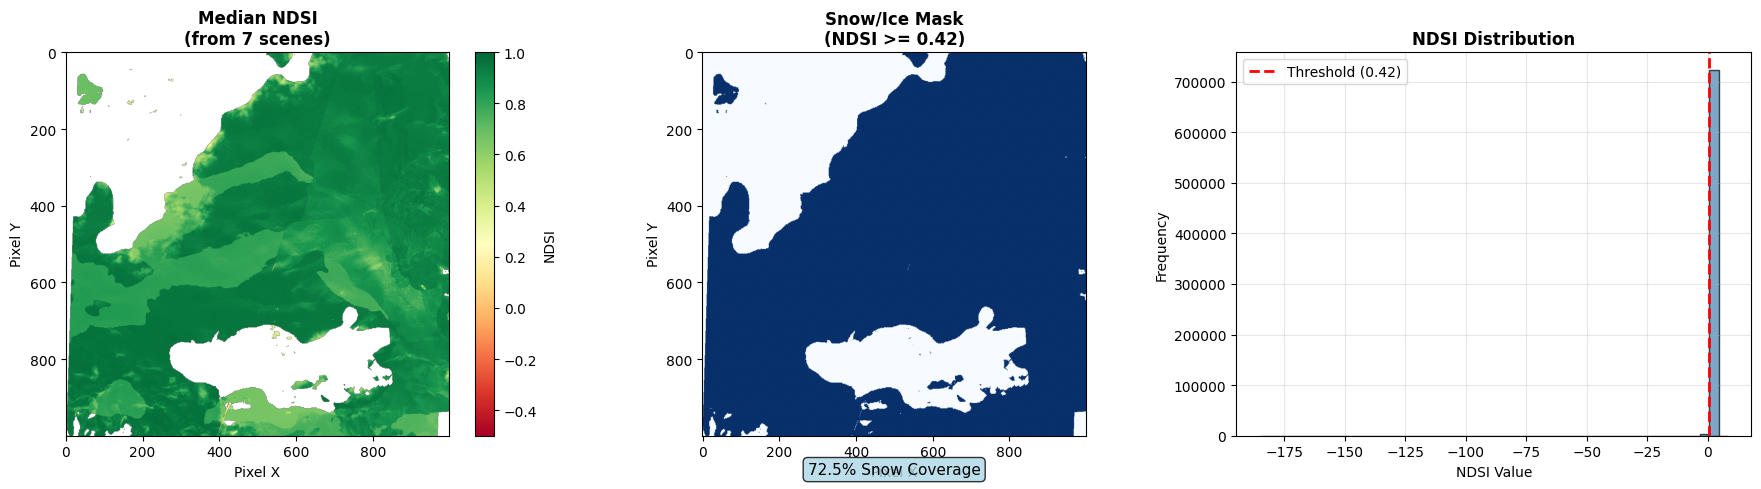


VISUALIZATION COMPLETE

✓ Left:   Median NDSI showing spectral snow index
✓ Middle: Binary snow mask (white = snow/ice detected)
✓ Right:  NDSI histogram with classification threshold

Interpretation:
- NDSI > 0.42: Snow/ice pixels (shown in white in middle plot)
- NDSI close to 0: Rock, vegetation
- NDSI < 0: Water, shadows
    


In [14]:
if result:
    # Create visualization of NDSI and snow mask
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Median NDSI
    im1 = axes[0].imshow(result['ndsi_median'].values, cmap='RdYlGn', vmin=-0.5, vmax=1.0)
    axes[0].set_title(f'Median NDSI\n(from {result["scene_count"]} scenes)', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Pixel X')
    axes[0].set_ylabel('Pixel Y')
    plt.colorbar(im1, ax=axes[0], label='NDSI')
    
    # Plot 2: Snow/Ice Mask
    axes[1].imshow(result['snow_mask'].values, cmap='Blues', vmin=0, vmax=1)
    axes[1].set_title(f'Snow/Ice Mask\n(NDSI >= {NDSI_THRESHOLD})', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Pixel X')
    axes[1].set_ylabel('Pixel Y')
    
    # Add percentage annotation
    axes[1].text(0.5, -0.1, f'{result["snow_percentage"]:.1f}% Snow Coverage', 
                 transform=axes[1].transAxes, ha='center', fontsize=11, 
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    # Plot 3: NDSI Histogram
    ndsi_flat = result['ndsi_median'].values.flatten()
    ndsi_flat = ndsi_flat[~np.isnan(ndsi_flat)]
    
    axes[2].hist(ndsi_flat, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[2].axvline(NDSI_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold ({NDSI_THRESHOLD})')
    axes[2].set_title('NDSI Distribution', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('NDSI Value')
    axes[2].set_ylabel('Frequency')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
    print("VISUALIZATION COMPLETE")
    print("=" * 70)
    print("""
✓ Left:   Median NDSI showing spectral snow index
✓ Middle: Binary snow mask (white = snow/ice detected)
✓ Right:  NDSI histogram with classification threshold

Interpretation:
- NDSI > 0.42: Snow/ice pixels (shown in white in middle plot)
- NDSI close to 0: Rock, vegetation
- NDSI < 0: Water, shadows
    """)
else:
    print("No results to visualize.")